<a href="https://colab.research.google.com/github/katlidakis/potential-data-scientist/blob/master/Ameshousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Google's logo](https://upload.wikimedia.org/wikipedia/commons/e/ef/Ames_Iowa_Main_Street_%28bannerportada_esvoy2%29.jpg)

  **Kaggle competition: Ames housing project**

<br>
This is my very first Notebook. I am going to visualize, analyze and interpret the Ames housing dataset while working with programming language R. The purpose of this notebook is to predict the final price of a house while having 79 variables for it, basically we will use less than 50, which describe almost every aspect of a house. I started working on this project to participate in Kaggle competition of building the best regression model and predicting the final price of the houses. I found this competition a perfect option for someone relevant to machine learning to test his skill set as a data analyst/scientist and learn more advanced regression techniques like random forest and gradient boosting.
<br>
<br>

**Importing useful libraries**

<br/>


In [ ]:
install.packages("DataExplorer")
install.packages("xgboost")
install.packages("data.table")
install.packages("mltools")
install.packages("glmnet")
install.packages("ggplot2")
library("DataExplorer")
library("xgboost")
library("data.table")
library("mltools")
library("glmnet")
library("ggplot2")

<br>

**Descriptive statistics of target variable**
<br>
<br>

As long as we imported all the libraries we are going to work with next step is to read our train and test sets. At this point, the most important thing is to check for missing values of both datasets but before doing this, I will start by examining the descriptive statistics of target variable which is SalesPrice.
<br/>
<br/>


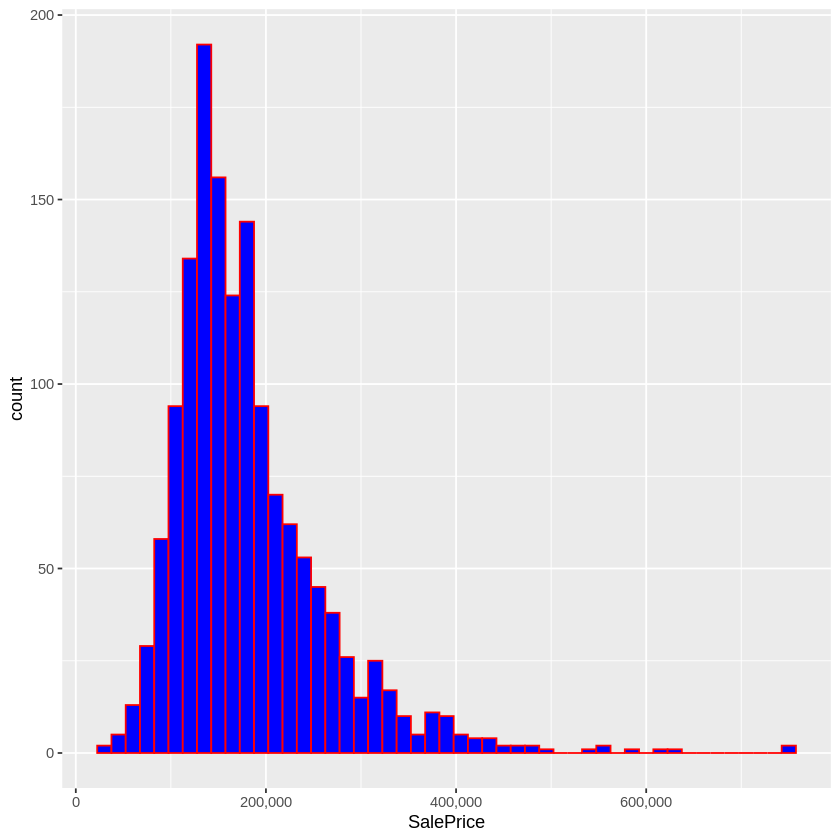

In [70]:
train<-read.csv("train.csv")
test<-read.csv("test.csv")
require(scales)
ggplot(train, aes(x=SalePrice)) + geom_histogram(binwidth = 15000 ,color="red",fill="blue")+ scale_x_continuous(labels = comma)

In [71]:
summary(train$SalePrice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34900  129975  163000  180921  214000  755000 

<br/>

It's pretty clear that we have a positive skewness and many outliers. The mean value for SalePrice is 180.000 while the median is 163.000. To respond to skewness towards large values a good idea is to log SalePrice when we will start modeling. 
<br/>
<br/>

<br>

**Feature engineering**
<br>
<br>
While we have to handle with so many features it means that some of them are useless to us and some other are useful. For example Neighborhood, is a good predictor for our model as it seems in the plot below because there is lot's of variation. On the other hand, Street is an irrelevant feature for us because almost all the houses, except 6, have the same type of road access. Another interesting variable which shows linearity with SalePrice is OverallQual which we will transform a little bit and TotalBsmtSF which will be combined with other variables but still will stay in our data as it is.


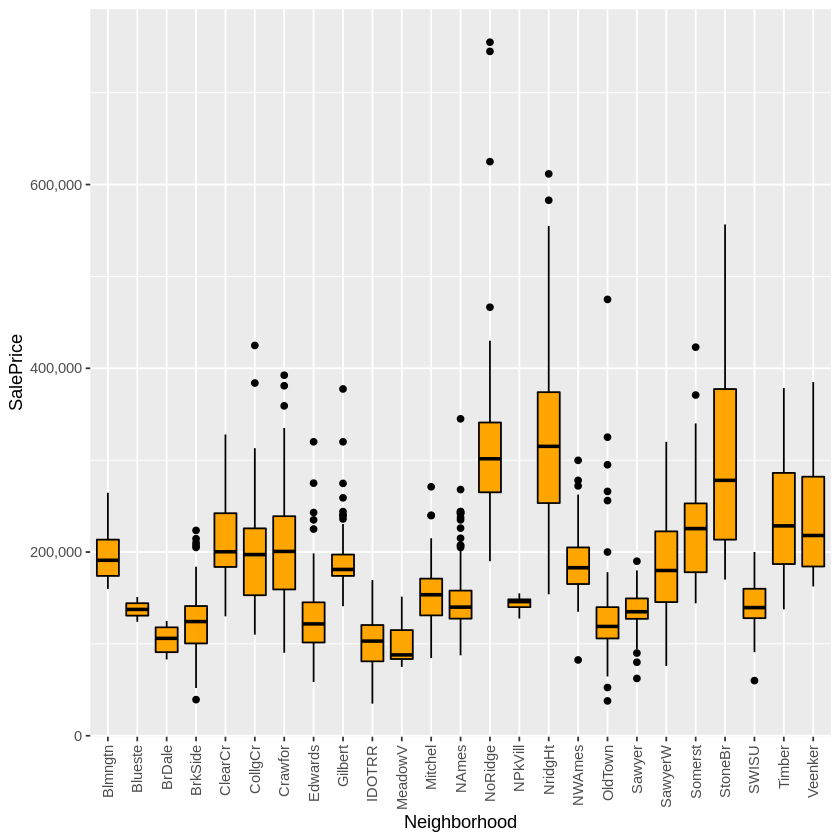

In [72]:
ggplot(train, aes(x=Neighborhood,y=SalePrice)) + geom_boxplot(color="black", fill="orange")+
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
scale_y_continuous(labels = comma)


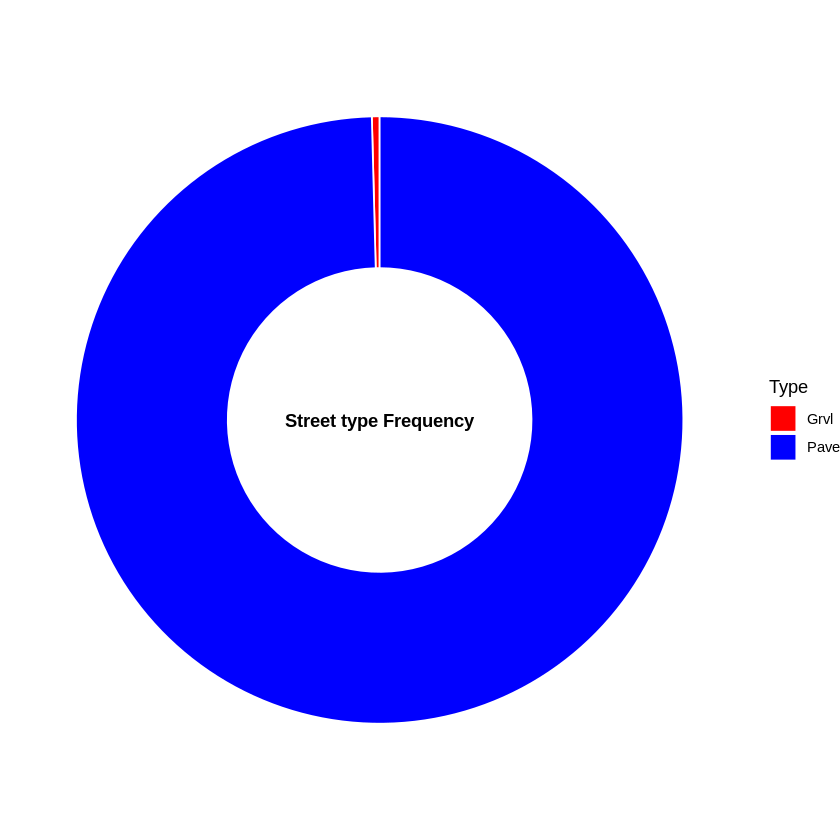

In [73]:
df<-as.data.frame(table(train$Street))
names(df)<-c("Type","Frequency")
ggplot(df, aes(x=2, y=Frequency, fill=Type))+
geom_bar(stat="identity", width=1,color="white") +
coord_polar("y", start=0)+theme_void()+xlim(0.5, 2.5)+
theme(plot.title = element_text(hjust=0.5,face="bold",size=12))+
scale_fill_manual(values = c("red","blue"))+
annotate(geom = 'text', x = 0.5, y = 0,fontface =2, label ="Street type Frequency")


`geom_smooth()` using formula 'y ~ x'



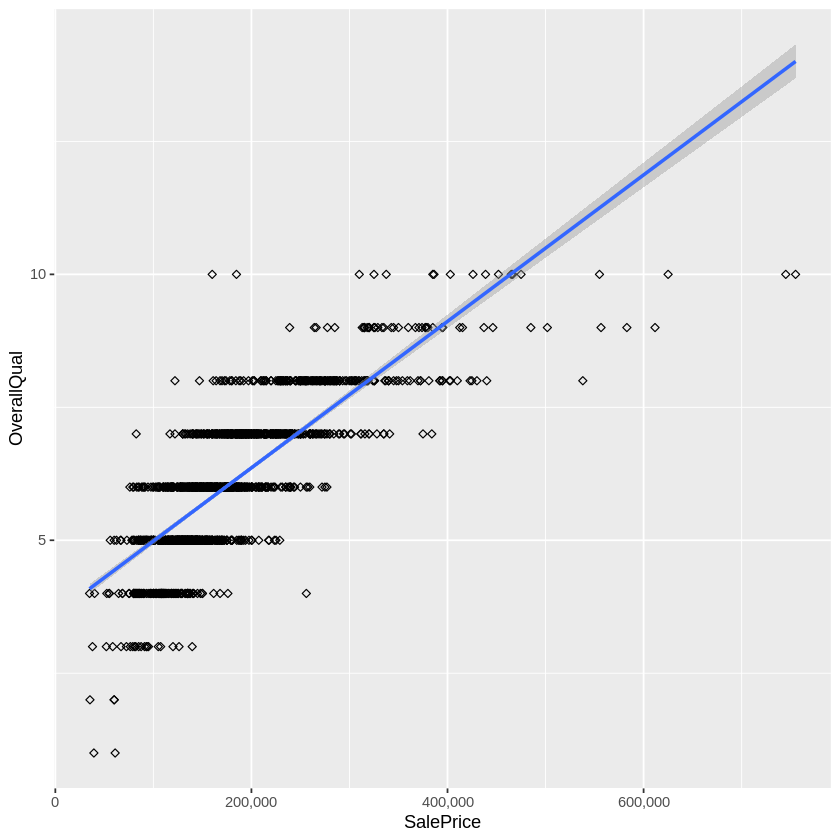

In [74]:
ggplot(train, aes(x=SalePrice,y=OverallQual)) + geom_point(shape=23) + geom_smooth(method="lm") + scale_x_continuous(labels = comma)

`geom_smooth()` using formula 'y ~ x'



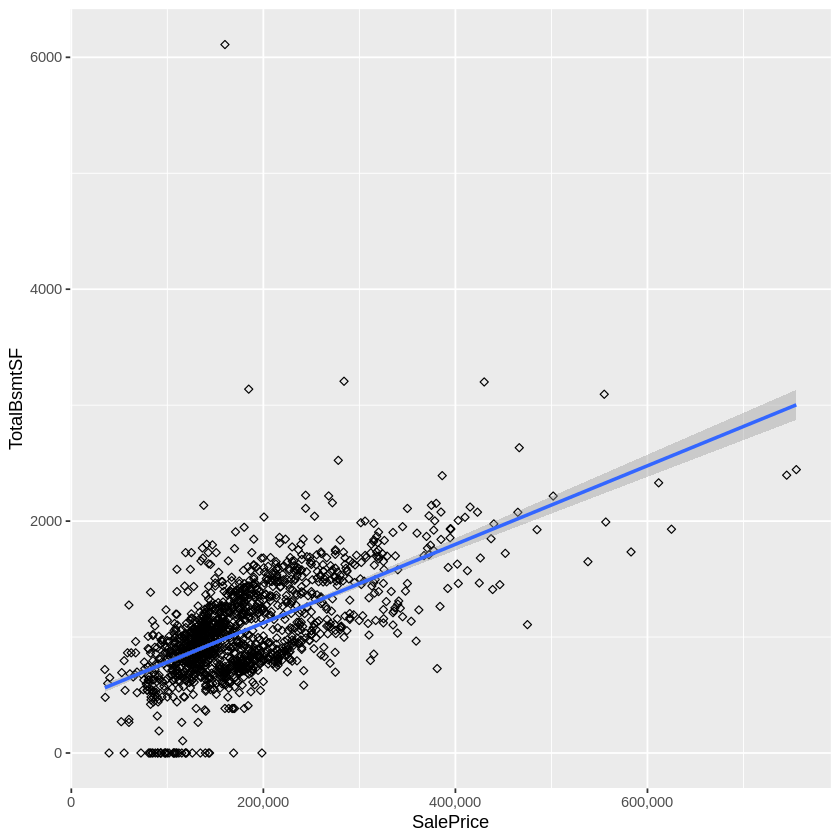

In [75]:
require(scales)
ggplot(train, aes(x=SalePrice,y=TotalBsmtSF)) + geom_point(shape=23) + geom_smooth(method="lm") + scale_x_continuous(labels = comma)

<br/>

**Missing values** 
<br/>
<br/>
Now that we have an idea of our data let's manipulate the missing values of our train and test set.


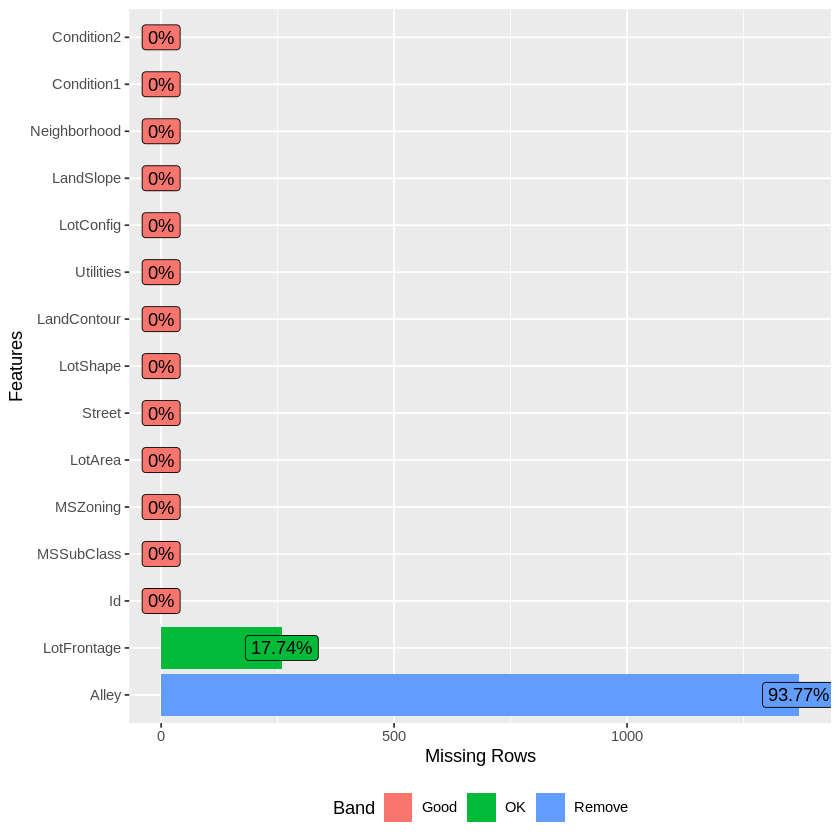

In [76]:
plot_missing(train[,1:15])

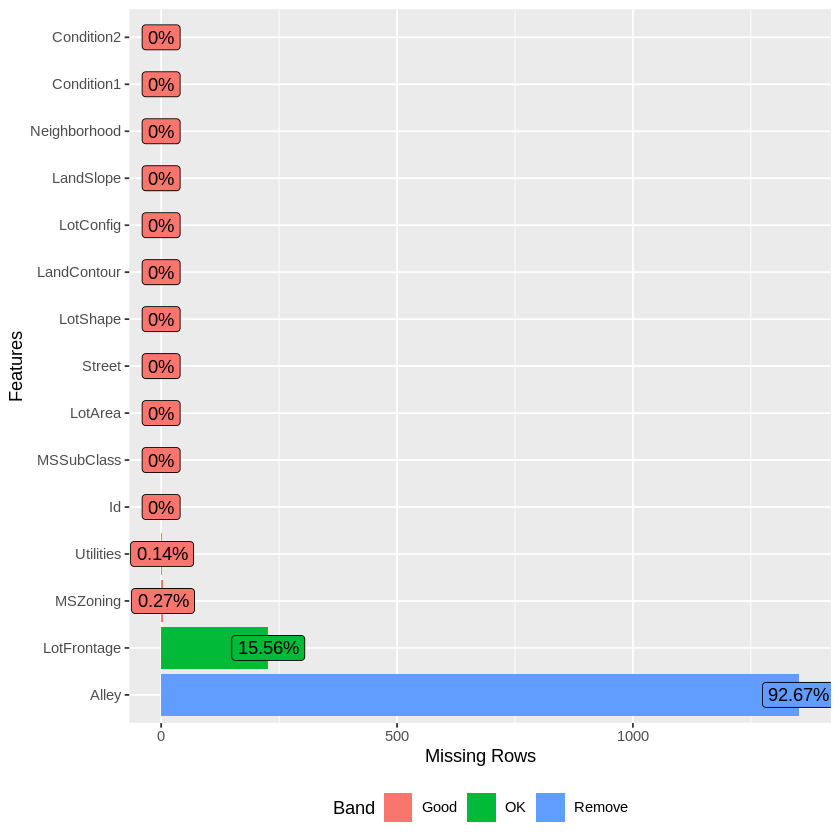

In [77]:
plot_missing(test[1:15])

<br/>

What we observe from both plots is that the distribution of missing values for both sets is similar so we should treat our two datasets as one.
Test dataset has one column less than the train dataset which is the SalePrice that we will try to predict. To combine them we have to add another column with 0s to our test set so we can work on them. The following commands do this job for us.
<br/>
<br/>


In [78]:
dim(train)
dim(test)
test$SalePrice<-c(rep(0,1459))
train<-rbind(train,test)
dim(train)

[1] 1460   81

[1] 1459   80

[1] 2919   81

<br/>

Our new train set contains our old train and test set and now we can start working on it. Let’s check our first columns:
<br/>
<br/>



In [79]:
head(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


<br/>

**Data manipulation**
<br/>
<br/>


Before start deleting columns that contain too many NA values we will try to combine some features in order to shorten the dimensions of our data frame and to work only with features that make sense.For example, the following 3 features describe the Total area of the house so a good idea is to sum them to a new variable and get rid of them after. Please note, we won't delete TotalBsmtSF, we show the reason above.
<br/>
<br/>

In [80]:
train$TotalArea<-train$X1stFlrSF+train$X2ndFlrSF+train$TotalBsmtSF


<br/>

Next features we will try to combine are those that describe the finished square feet area of the house.
<br/>
<br/>


In [81]:
train$TotalFinSF<-train$BsmtFinSF1+train$BsmtFinSF2+train$X1stFlrSF+train$X2ndFlrSF


<br/>

Now we will delete the features that we used to make our two new variables.
<br/>
<br/>


In [82]:
train$BsmtFinSF1<-NULL
train$BsmtFinSF2<-NULL
train$X1stFlrSF<-NULL
train$X2ndFlrSF<-NULL


<br/>

We will continue doing this job with other features as well. For example OverallCond and OverallQual could be one variable. Also, variables that describe the number full baths and half baths of the house can merge to one column. Same thing can happen with the porches. The result will be to get rid of 8 variables in total as it seems above.
<br/>
<br/>


In [83]:
train$QualCond<-(train$OverallCond*train$OverallQual)/100
train$OverallCond<-NULL
train$OverallQual<-NULL

train$TotBath<-train$BsmtFullBath+(0.5*train$BsmtHalfBath)+train$FullBath+(0.5*train$HalfBath)
train$BsmtFullBath<-NULL
train$BsmtHalfBath<-NULL
train$HalfBath<-NULL
train$FullBath<-NULL

train$TotPorch<-train$OpenPorchSF+train$EnclosedPorch+train$X3SsnPorch+train$ScreenPorch+train$WoodDeckSF
train$OpenPorchSF<-NULL
train$EnclosedPorch<-NULL
train$X3SsnPorch<-NULL
train$ScreenPorch<-NULL
train$WoodDeckSF<-NULL

<br/>

If we check the dimensions of our data frame it's clear that we did a great job without losing any information of our original dataset.
<br/>
<br/>


In [84]:
dim(train)

[1] 2919   71

<br/>

Our next move is to seperate those houses that have a pool with those who don't. It's pretty obvious that if we look for houses with pool we will expect higher SalePrize so it makes sense to add a new binary varible.
<br/>
<br/>


In [85]:
train$Pool<-c(rep(2,2919))
for (i in 1:nrow(train)){
  if (train$PoolArea[i]==0) {
    train$Pool[i]<-c(0)
  } else {
    train$Pool[i]<-c(1)
  }
}
train$Pool<-as.factor(train$Pool)

train$PoolQC<-NULL
train$PoolArea<-NULL

<br/>

Another good idea which works well with our categorical variables is to check the frequency of their mode, the value that appears the most, and set a number that if the percentage is greater than we will delete the variable. For example, if the Street variable which describes the type of road access to property has the same type for 99% of houses leads to that Street column is not important for our analysis.
<br/>
<br/>

But before we start we must replace all the missing values. Features that contain NAs does not necessarily mean that the value is missing. For example, NAs for GarageCars mean that the house does not have a garage so we will replace NA with 0. It works like this with other features too. We will use the mean for continuous variables with missing values and the mode for categorical variables.

In [86]:
mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

In [87]:
train$TotalBsmtSF[is.na(train$TotalBsmtSF)]<-mean(train$TotalBsmtSF,na.rm=TRUE)
train$SaleType[is.na(train$SaleType)]<-mode(train$SaleType)
train$TotalArea[is.na(train$TotalArea)]<-mean(train$TotalArea,na.rm=TRUE)
train$TotalFinSF[is.na(train$TotalFinSF)]<-mean(train$TotalFinSF, na.rm=TRUE)
train$TotBath[is.na(train$TotBath)]<-mean(train$TotBath,na.rm = TRUE)
train$KitchenQual[is.na(train$KitchenQual)]<-train$HeatingQC[is.na(train$KitchenQual)]
train$GarageCars[is.na(train$GarageCars)]<- 0
train$BsmtUnfSF[is.na(train$BsmtUnfSF)]<-0
train$LotFrontage[is.na(train$LotFrontage)]<-0
train$GarageArea[is.na(train$GarageArea)]<-0
train$MasVnrArea[is.na(train$MasVnrArea)]<- 0
train$MasVnrArea[is.na(train$MasVnrArea)]<- 0
train$Electrical[is.na(train$Electrical)]<-mode(train$Electrical)
train$Functional[is.na(train$Functional)]<-mode(train$Functional)
train$MSZoning[is.na(train$MSZoning)]<-mode(train$MSZoning)

<br/>

We will set NAs of GarageYrBlt with YearBuilt value, also our data have a mistake, there is a GarageYrBuilt value of 2207 which we will replace with the YearBuilt value of the house.
<br/>
<br/>

In [88]:
train$GarageYrBlt[is.na(train$GarageYrBlt)]<-train$YearBuilt[is.na(train$GarageYrBlt)]
train$GarageYrBlt[train$GarageYrBlt==2207]<-train$YearBuilt[train$GarageYrBlt==2207]

In [89]:
train$Fence<-as.character(train$Fence)
train$Fence[is.na(train$Fence)]<- "No"
train$Fence<-as.factor(train$Fence)

train$Exterior1st<-as.character(train$Exterior1st)
train$Exterior1st[is.na(train$Exterior1st)]<- "No"
train$Exterior1st<-as.factor(train$Exterior1st)

train$Exterior2nd<-as.character(train$Exterior2nd)
train$Exterior2nd[is.na(train$Exterior2nd)]<- "No"
train$Exterior2nd<-as.factor(train$Exterior2nd)

train$GarageType<-as.character(train$GarageType)
train$GarageType[is.na(train$GarageType)]<- "No"
train$GarageType<-as.factor(train$GarageType)

train$FireplaceQu<-as.character(train$FireplaceQu)
train$FireplaceQu[is.na(train$FireplaceQu)]<- "No"
train$FireplaceQu<-as.factor(train$FireplaceQu)

train$Alley<-as.character(train$Alley)
train$Alley[is.na(train$Alley)]<- "No"
train$Alley<-as.factor(train$Alley)

train$BsmtQual<-as.character(train$BsmtQual)
train$BsmtQual[is.na(train$BsmtQual)]<- "No"
train$BsmtQual<-as.factor(train$BsmtQual)

train$BsmtCond<-as.character(train$BsmtCond)
train$BsmtCond[is.na(train$BsmtCond)]<- "No"
train$BsmtCond<-as.factor(train$BsmtCond)

train$BsmtExposure<-as.character(train$BsmtExposure)
train$BsmtExposure[is.na(train$BsmtExposure)]<- "No"
train$BsmtExposure<-as.factor(train$BsmtExposure)

train$BsmtFinType1<-as.character(train$BsmtFinType1)
train$BsmtFinType1[is.na(train$BsmtFinType1)]<- "No"
train$BsmtFinType1<-as.factor(train$BsmtFinType1)

train$BsmtFinType2<-as.character(train$BsmtFinType2)
train$BsmtFinType2[is.na(train$BsmtFinType2)]<- "No"
train$BsmtFinType2<-as.factor(train$BsmtFinType2)

train$GarageFinish<-as.character(train$GarageFinish)
train$GarageFinish[is.na(train$GarageFinish)]<- "No"
train$GarageFinish<-as.factor(train$GarageFinish)

train$GarageQual<-as.character(train$GarageQual)
train$GarageQual[is.na(train$GarageQual)]<- "No"
train$GarageQual<-as.factor(train$GarageQual)

train$GarageCond<-as.character(train$GarageCond)
train$GarageCond[is.na(train$GarageCond)]<- "No"
train$GarageCond<-as.factor(train$GarageCond)

train$MiscFeature<-as.character(train$MiscFeature)
train$MiscFeature[is.na(train$MiscFeature)]<- "No"
train$MiscFeature<-as.factor(train$MiscFeature)

train$MasVnrType<-as.character(train$MasVnrType)
train$MasVnrType[is.na(train$MasVnrType)]<- "None"
train$MasVnrType<-as.factor(train$MasVnrType)


<br/>

At this point we will delete the ID and MoSold columns  which are not helpful for our analysis.
<br/>
<br/>

In [90]:
train$Id<-NULL
train$MoSold<-NULL

<br/>

With the following function we can find the percentage of the mode for every categorical variable.
<br/>
<br/>

In [91]:
repvalues=function(x){
  check=table(x, useNA = "always")
  check2=check[which.max(check)]
  return (cbind(check2,len=length(x)))
}

<br/>

We now loop this function over all variables:
<br/>
<br/>

In [92]:
useless_var=function(x){
  mode_count=t(sapply(x,function(y)repvalues(y)))
  return (mode_count)
}

u<-useless_var(train)
per<-data.frame(u[,1]/u[,2])
colnames(per)<-"Per"
head(per)


,Per
,<dbl>
MSSubClass,0.36964714
MSZoning,0.77732100
LotFrontage,0.16649538
LotArea,0.01507366
Street,0.99588900
Alley,0.93216855


<br/>

As we discussed before, variables which their mode is more than 90% of other categories are useless and we are going to delete them.
<br/>
<br/>

In [93]:
train$Street<-NULL
train$Alley<-NULL
train$Utilities<-NULL
train$LandSlope<-NULL
train$Condition2<-NULL
train$RoofMatl<-NULL
train$Heating<-NULL
train$CentralAir<-NULL
train$Electrical<-NULL
train$LowQualFinSF<-NULL
train$KitchenAbvGr<-NULL
train$Functional<-NULL
train$PavedDrive<-NULL
train$GarageCond<-NULL
train$MiscVal<-NULL
train$MiscFeature<-NULL
train$MSSubClass<-NULL
train$LotFrontage<-NULL
train$MasVnrArea<-NULL
train$BsmtUnfSF<-NULL
train$BedroomAbvGr<-NULL
train$YrSold<-NULL
train$TotPorch<-NULL

<br/>

Our last move will be to remove some outliers. We should be careful when we remove rows because we don't want to change our original test set. In this case all rows are from our original train set so this will not affect our test set and we will not skip any house from which we have to predict its prize.
<br/>
<br/>

In [94]:

train=train[!(train$LotArea>150000),]
train=train[!(train$GarageYrBlt<1873),]

In [95]:
dim(train)

[1] 2915   45

Before we get on modeling we will log our continuous variables. I will prove my point below where the first plot is the distribution of TotalArea before the logarithm and the second is after.

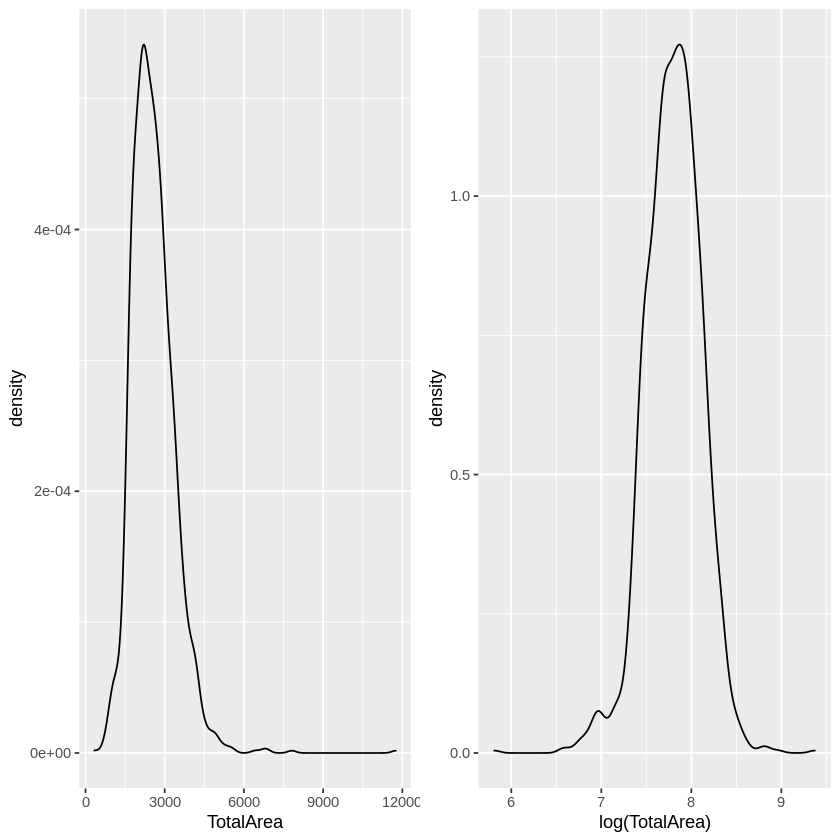

In [96]:
require(gridExtra)
original <- ggplot(train[1:1456,], aes(x=TotalArea)) + geom_density()
log <- ggplot(train[1:1456,], aes(x=log(TotalArea))) + geom_density()
grid.arrange(original, log, ncol=2)

In [97]:
train$GarageArea[train$GarageArea<1.01]<-1.01
train$GarageArea<-log(train$GarageArea)
train$TotalArea<-log(train$TotalArea)
train$LotArea<-log(train$LotArea)
train$TotalFinSF<-log(train$TotalFinSF)
train$SalePrice[1:1456]<-log(train$SalePrice[1:1456])

<br/>

**Data modeling**
<br/>
<br/>
After cleaning all my data the next step is to start building my model with the features that I included in my dataset.
<br/>
<br/>
I am going to use XGBoost function. XGBoost is the leading model for many Kaggle competition wins. This model will be my primary one, I will also use a Ridge regression model as my secondary model. Ridge regression is an etension of linear regression where the loss function is modified to minimize the complexity of the model. 
<br/>
<br/>
Before I start my modeling I have to fix my data again with the following commands




In [98]:
newdata <- one_hot(as.data.table(train))

trainset<-newdata[1:1456,]
testset<-newdata[1457:2915,]
testset$SalePrice<-NULL

label= trainset$SalePrice
trainset$SalePrice<-NULL

train.data = as.matrix(trainset)
test.data = as.matrix(testset)

dtrain<- xgb.DMatrix(data = train.data, label= label)
dtest <- xgb.DMatrix(data = test.data)

<br/>
In order to work with XGBoost I have to set a few parameters that can affect my model's accuracy.
<br/>
<br/>



In [ ]:
default_param<-list(
  objective = "reg:linear",
  booster = "gbtree",
  eta=0.05,
  gamma=0,
  max_depth=3, 
  min_child_weight=4,
  subsample=1,
  colsample_bytree=1
)

xgbcv <- xgb.cv( params = default_param, data = dtrain, 
                 nrounds = 1000, nfold = 5, showsd = T, 
                 stratified = T, print_every_n = 40,
                 early_stopping_rounds = 10, maximize = F)

<br/>

Early stopping causes the model to stop iterating when the validation score stops improving. It's ideal to set a high value for nrounds and then use early_stopping_rounds to find the optimal time to stop iterating. In our case the process stopped after 334 rounds. 
<br/>
<br/>


In [ ]:
xgb_mod = xgb.train(data = dtrain, params=default_param, nrounds=334)
XGBpred = predict(xgb_mod, dtest)

<br/>

And now I will build my Ridge regression model.
<br/>
<br/>

In [101]:
lambdas <- 10^seq(3, -2, by = -.1)
cv_fit <- cv.glmnet(train.data, label, alpha = 0, lambda = lambdas)
opt_lambda <- cv_fit$lambda.min
fit <- cv_fit$glmnet.fit
ridgepred <- predict(fit, s = opt_lambda, newx = test.data)


<br/>

My last move will be to combine my two models as I said before but with more weight on my XGBoost model. 
<br/>
<br/>

In [102]:
Subprice<-0.25*ridgepred+0.75*XGBpred

submission<-exp(Subprice)
Id<-c(1461:2919)
df<-data.frame(Id,submission)
colnames(df)<-c("ID","SalePrice")
write.csv(df,'submission.csv')


<br/>

Now I am ready to post my submission for the competition in Kaggle. The result of my work will be a RMSE value of 0.12169 which places me at number 636 of the leaderboard which contains 4850 submissions. That means that I am at top 14% of competitors.
<br/>
<br/>